In [2]:
URL = None
assert URL is not None

In [9]:
!rm -rf results
!curl -s {URL} |tar -xzf -
!mkdir -p results

import requests
import json
import re
import glob
from joblib import Parallel, delayed
from tqdm import tqdm_notebook as tqdm
import time

def func(data):
    filename = data['filename']
    region = data['region']
    m = re.compile("sbottom_(\d+)_(\d+)_(\d+)").search(filename).group(0)
    outname = 'results/region{}.result.{}.json'.format(region,m)
    for i in range(10):
        try:
            d = requests.post(
                'https://us-central1-nimble-valve-236407.cloudfunctions.net/region{}'.format(region),
                data = open(filename), headers = {'Content-Type': 'application/json'}
            ).json()
            json.dump(d,open(outname,'w'))
            break
        except:
            pass#retry

In [11]:
cA = [{'region': 'A', 'filename': f} for f in glob.glob('RegionA/patch*_60.json')]
cC = [{'region': 'C', 'filename': f} for f in glob.glob('RegionC/patch*_60.json')]
configs = cA[:] + cC[:]

from multiprocessing import Pool
pool = Pool(25)
for _ in tqdm(pool.imap_unordered(func, configs),total = len(configs)):
    pass
pool.close()
pool.join()

In [13]:
!ls -lrt results/regionC.result.sbottom_*_*_*|wc -l

148


In [14]:
import ROOT
import subprocess
import shlex
from plotting import harvest_results, plotit

harvest_results()
subprocess.call(shlex.split(
    'multiplexJSON.py -i results/harvest.RegionA.json results/harvest.RegionC.json  --modelDef msb,mn2,mn1 -o results/multiplex.json'
))
subprocess.call(shlex.split(
'harvestToContours.py -i results/multiplex.json -o results/multiplex.root -x msb -y mn2'
))
plotit()

Welcome to JupyROOT 6.12/07
results/regionA.result.sbottom_*_*_*.json
results/regionB.result.sbottom_*_*_*.json
results/regionC.result.sbottom_*_*_*.json


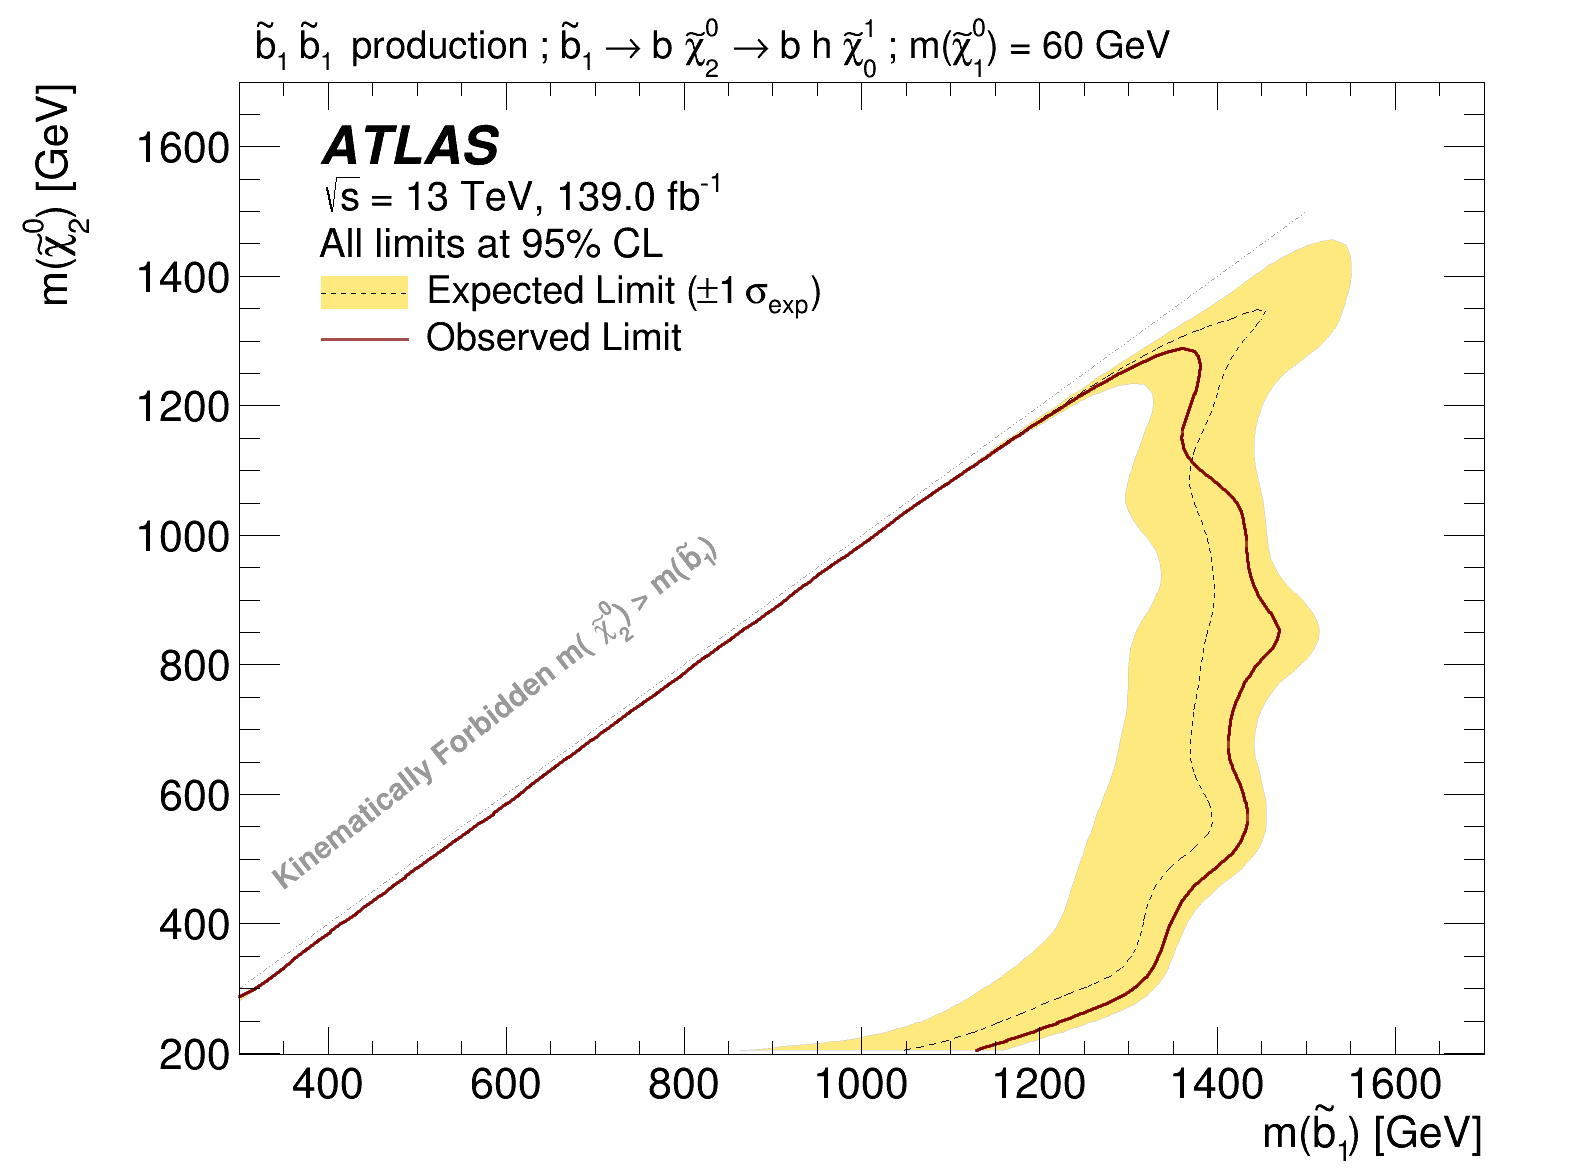

In [15]:
ROOT.gPad.Draw()